# T-DAB Challenge: Marine Electronics Company

## Part II - B) Feature Engineering + Time Series Analysis with LSTM Architecture  


### Your second task is to build a model that will alert sailors of tacking event happening in the future.

Your supervisor told you that on top of whatever you come up with, what you should definitely do is "tack prediction".

```“A tack is a specific maneuver in sailing and alerting the sailor of the necessity to tack in the near future would bring some advantage to them compared to other sailors, who would have to keep an eye out on the conditions all the time to decide when to tack”``` he writes in his email. The supervisor, who has some experience in sailing labels the tacks in the data from the client (added as `Tacking` column in the data).

<b>[Wikipedia](https://en.wikipedia.org/wiki/Tacking_(sailing)#:~:text=Tacking%20is%20a%20sailing%20maneuver,progress%20in%20the%20desired%20direction.)<b>
```Tacking is a sailing maneuver by which a sailing vessel, whose desired course is into the wind, turns its bow toward the wind so that the direction from which the wind blows changes from one side to the other, allowing progress in the desired direction.```

In [1]:
# Importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Set seaborn style 
sns.set(style="darkgrid")
sns.set(font_scale=1.5)

In [2]:
# Import all relevant scikit-learn modules

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
SEED = 42

# Feature Preprocessing and Engineering
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ROC-AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# DTC, KNN, Logistic Regression, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


#### Feature Reference

In [3]:
# Importing features' descriptions
var_dict = pd.read_json('./data/data_dict.json')
var_dict.transpose().sort_values('units')

,name,units,range,description
TensPilote,VoltageDrawn,Volts,None,Voltage drawn by the system of one of its parts
Longitude,Longitude,degrees,"[0, 360]",Longitudinal coordinate
Barre,RudderAng,degrees,None,Rudder angle
Latitude,Latitude,degrees,"[0, 360]",Latitudinal coordinate
Derive,Leeway,degrees,None,
Route,HeadingTrue,degrees,None,true heading. True heading - heading over grou...
CapFond,HoG,degrees,None,heading over ground
CapMagPil,HeadingMag,degrees,None,magnetic heading
3DH_Roulis,Roll,degrees,None,"Roll, also equals to -Heel"
AngVentApp,AWA,degrees,None,Apparent Wind Angle


In [4]:
# Yaw description
var_dict['Route'].description

'true heading. True heading - heading over ground = Yaw'

In [5]:
# Grouping our (27) features by similar categories / units 

# Speed Group 1 [knots]
wind_sp_cols = ['TWS', 'AWS', 'WSoG']

# Speed Group 2 [knots]
ship_sp_cols = ['SoG', 'SoS', 'AvgSoS', 'VMG']

# Direction Group 1 [degrees]
direction_cols = ['TWA', 'AWA', 'TWD']

# Direction Group 2 [degrees]
heading_cols = ['HeadingMag', 'HoG', 'HeadingTrue']

# Current Group
current_cols = ['CurrentDir', 'CurrentSpeed']

# Axes Group 1 [degrees]
axes_cols = ['Roll', 'Pitch', 'Yaw']

# Axes Group 2 [degrees] - Rudder (Timon)
angle_cols = ['RudderAng', 'Leeway']

# Pilote Group [degrees]
voltgage_cols = ['VoltageDrawn'] 

# GeoLoc Group [degrees]
geo_cols = ['Longitude', 'Latitude']

# Temperature Group [Celcius]
temperature_col = ['AirTemp']

# DateTime index
datetime_col = 'DateTime'

# Mode Pilote 
mp_col = 'ModePilote'

# Target Variable
target = 'Tacking'

### Feature Engineering & Transformation

- In order for our models to perform well we need to perform some transformation to our raw variables:
    - Angle variables such as: `['TWD', 'CurrentDir', 'HoG', 'HeadingTrue' ,'HeadingMag']`  were converted into radians and expressed in terms of their `sin` and `cosine`. This is because I want to capture the fact that 360 degrees is closer to 0 than, for instance, 90 degrees. This transformation also has the advantage of mapping variables to [-1, +1] range.
    - The variable `Yaw` with range [-360,+360] could be re-expressed by adding 360 and then computing sine and cosine as well.
    - Highly skewed (positive) distributions with long tails to the right can become more normally distributed after applying a LOG-transformation. This is the case of: CurrentSpeed `CurrentSpeed ` and Voltage Drawn (`VoltageDrawn`)
    - Normally behaved variables were just standarize: `'TWA'`, `'AWA'` , Pitch (`Pitch`), Roll(`Roll`), Rudder Angle (`RudderAng`), Leeway (`Leeway`), WindSpeed Over Ground (`WSoG`), Speed Over Ground (`SoG`), Speed Over Surface (`SoS`) and Velocity Made Good (`VMG`). 
    - Average Speed Over Ground (`AvgSos`) was binned in 5 categories from low to high speeds.
    - For `TWS` and `AWS` that show some skewness to the left a `BoxCox` transformation can be tried
    - Air Temperature (`AirTemp`) looks like a bimodal distribution but I approximated it with a Normal standarization as a first approach
    
- With Tree Based Models (with no Feature Engineering) I was getting really good performance on my validaton set but it went drastically down when predicting on the Holdout (Unseen Test Set) set I suspected heavy overfitting. I also I decided to analize the distribution of the features in my available data and tried to spot variables that showed notable differences between my Training-Validation set with respect to the Test set. Based on this analysis I tried to come up with some newly Engineered Features that could acount for drastical changes in the distribution of "unseen" data. For instance: 

    - The variables `'SoG'`, `'SoS'`, `'AvgSoS'`, `'VMG'` showed similar ditributions in Train-Test BUT they showed peaks at 0 counts mostly belonging to the first hours of available data. For this reason I thought it might be a good idea to split these variables in groups representing the two different behaviors. One that accounts for the high number of 0 counts and a second that accounts for the continuous (normal shape) distribution of values. The idea behind this, is that if I train my model on a large number of cases where the ship has nearly 0 velocity and later on I want to predict `Tacking` under non zero velocity, my model would have learn patterns from a situation that is not useful for the predictions I would like to make in the future. 
    - In the end, I decided that the best way to proceed was to discard the period of time with measurements exhibing low speeds from my Training-Validation set and only consider data from the moment that Speed variables started growing. This reduced the amount of True `Tacking` labels that I had to train my models but will most likely help `Tacking` prediction for ships sailing at higher speeds.

- Voltage seemed to fluctuate around 11-13 volts, but there it also showed some skewed values around 13.5 and 14 both in the Training and Test Set.

Note A) I might leave `VoltageDrawn` and `AirTemp` out of my first modeling iteration as their boxplots do not show substantial differences between the positive and negative `Tacking` label and their distributions are not so "well behave". `AirTemp` looks bimodal why `VoltageDrawn` shows skewness to the right of its distribution.

Note B) I transform every feature at once and then only keep the ones that behave best for my initial analysis

In [6]:
# Read Training Data
df = pd.read_csv('./data/seen_data.csv',header = 0)
df['DateTime'] = pd.to_datetime(df['DateTime'])

###############################
# Transforming positive angles
def positive_angle_transforms(df, columns): 
    """
    Function to express angle features in terms of cosine and sine
    This should capture the fact that 360 degrees in close to 0 degrees 
    """
    for col in columns:
        
        if col == 'Yaw':
            df[col+'_cos'] = np.cos(df[col] + 360) * np.pi / 180
            df[col+'_sin'] = np.sin(df[col] + 360) * np.pi / 180
        else:
            df[col+'_cos'] = np.cos(df[col] * np.pi / 180)
            df[col+'_sin'] = np.sin(df[col] * np.pi / 180)
        
    return df

positive_angle_cols = ['TWD', 'CurrentDir', 'HoG', 'HeadingTrue' ,'HeadingMag', 'Yaw']
df = positive_angle_transforms(df, positive_angle_cols)

###############################
# Transforming negative angles
def negative_angle_transforms(df, columns):
    for col in columns:
        
        df[col+'_cos'] = np.cos((df[col] + 360) * np.pi / 180)
        df[col+'_sin'] = np.sin((df[col] + 360) * np.pi / 180)
    
    return df

negative_angle_cols = ['TWA', 'AWA']
df = negative_angle_transforms(df, negative_angle_cols)

###############################
# Instantiate PowerTransformer
log_transformer = PowerTransformer()

# Log variables
pre_log_vars = ['CurrentSpeed', 'VoltageDrawn']
log_vars = ['log_CurrentSpeed', 'log_VoltageDrawn']

# Fit-Trasform log columns
df[log_vars] = log_transformer.fit_transform(df[pre_log_vars])

###############################
# Instantiate PowerTransformer (Box-Cox)
bc_transformer = PowerTransformer(method='box-cox')

# BoxCox variables
pre_bc_vars = ['TWS', 'AWS']
bc_vars = ['bc_TWS', 'bc_AWS']

# Fit-Trasform BoxCox columns
df[bc_vars] = bc_transformer.fit_transform(df[pre_bc_vars])

################################################################################################
# Create range of categories for SoS. Its distribution is not so "well behaved". 
# If I want to include it in my analysis. I would use One Hot Encoder on this categorical variable
label_ranges = [0, 2, 4, 6, 8, np.inf]
label_names = [0, 1, 2, 3, 4]

# Create wait_type column
df['AvgSoS_cat'] = pd.cut(df['AvgSoS'], bins = label_ranges, 
                                labels = label_names)

df['AvgSoS_cat'] = df['AvgSoS_cat'].astype('int') 

###############################
# Instantiate Standard Scaler
std_scaler = StandardScaler()

# Variables to scale
pre_std_vars = ['Pitch','Roll','RudderAng', 'Leeway', 'WSoG', 'SoG', 'SoS', 'VMG', 'AirTemp',
                'log_CurrentSpeed', 'log_VoltageDrawn',
                'bc_TWS', 'bc_AWS']

# Fit-Transform columns
std_df = pd.DataFrame(std_scaler.fit_transform(df[pre_std_vars]))
std_df.columns = ['std_' + col for col in pre_std_vars]

#####################################################################
# Concatenate Raw Variables + Angle Variables + Standarized Variables
df = pd.concat([df, std_df], axis=1)

# Create a list of column names to drop/keep
to_drop = ['TWS', 'AWS', 'WSoG'] + \
['SoS', 'AvgSoS', 'SoG','VMG'] + \
['AWA','TWA', 'TWD'] + \
['HoG', 'HeadingTrue' ,'HeadingMag', 'Yaw'] + \
['CurrentDir', 'CurrentSpeed'] + \
['Roll','Pitch'] + \
['RudderAng', 'Leeway'] + \
['VoltageDrawn'] + \
['Longitude', 'Latitude'] + \
['AirTemp'] + \
['DateTime'] + \
['ModePilote'] + \
['log_CurrentSpeed', 'log_VoltageDrawn', 'bc_TWS','bc_AWS'] +\
['std_bc_TWS', 'std_bc_AWS', 'std_SoS', 'AvgSoS_cat', 'std_Roll', 'std_AirTemp', 'std_log_VoltageDrawn' ] + \
['AWA_cos', 'AWA_sin', 'HoG_cos', 'HeadingTrue_cos', 'HoG_sin', 'HeadingTrue_sin', 'AWA_cos', 'AWA_sin']

keep = ['TWS', 'AWS', 'WSoG'] + \
['SoS', 'AvgSoS', 'SoG','VMG'] + \
['AWA','TWA', 'TWD'] + \
['HoG', 'HeadingTrue' ,'HeadingMag', 'Yaw'] + \
['CurrentDir', 'CurrentSpeed'] + \
['Roll','Pitch'] + \
['RudderAng', 'Leeway'] + \
['VoltageDrawn'] + \
['Longitude', 'Latitude'] + \
['AirTemp'] + \
['DateTime'] + \
['ModePilote'] 

std_vars = ['std_WSoG', 'std_SoG', 'std_VMG', 'std_Pitch', 'std_RudderAng', 'std_Leeway', 'std_log_CurrentSpeed']
angle_vars = ['TWA_cos', 'TWA_sin',  'TWD_cos', 'TWD_sin', 'HeadingMag_cos', 'HeadingMag_sin', 'Yaw_cos', 'Yaw_sin', 'CurrentDir_cos', 'CurrentDir_sin']

# Drop all unwanted variables
df = df.drop(to_drop, axis=1)

### Feature Selection

Feature selection is an iterative process. To start my analysis I did the following:

- I discarded variables that were highly correlated (See EDA pair plots and Correlation Matrix). Addittionally, I tried to keep (when possible) those variables that appeared Normally distributed (See EDA histograms) in EDA from Part I.
- I payed attention to Normally Distributed features because after trying Tree Based models I wanted to try models such as Logistic Regression, SVMs and Neural Network architectures. Those models require me to preprocess and standarize the variables of interest.
- I also dropped unique identifiers such as: `Date`, `Latitude` and `Longitude`. These last two were very granular variables, increasing monotonously and seemed to give little information on the target variable.
- I also discarded `ModePilote` variable because I did not have information on how that variable was generated and I wanted to avoid potential Data Leakage.

Variable selection:

- I chose Wind Speed Over Ground (`WSoG`) over the highly correlated True Wind Speed (`TWS`) and Apparent Wind Speed (`AWS`)
- I chose Speed Over Ground (`SoG`) over the highly correlated Speed Over Surface (`SoS`) (also linked to `VMG`)  
- I am also intrested in keeping Velocity Made Good (`VMG`) signal
    - Eric Note: Depending on wind speed, there will be an optimum wind angle to sail in order to have the best velocity to the point we are trying to get to. VMG may also be better on one tack or the other depending on shifts in wind direction. It is a key indicator for making decisions like sail choice, tacking/gybing, and wind angle to sail.
- I could try adding and removing Average Speed Over Surface (`AvgSoS`). Notice its distribution is far from Normal.
- I chose True Wind Angle (`TWA`) over the highly correlated Apparent Wind Angle (`AWA`)
- I also kept the "well behaved" True Wind Direction (`TWD`)
- I also kept Magnetic Heading (`HeadingMag`).
- I also included `Yaw` = True heading - Heading Over ground . An leave that combines Heading Over Ground (`HoG`) and True Heading (`HeadingTrue`). 
- I kept `Pitch` over the correlated `Roll`
- I kept both `RudderAngle` and `Leeway`
- `VoltageDrawn`, `AirTemp`, `CurrentDir` and `CurrentSpeed` also seem to be independent variables that fluctuate on a daily basis, I could try adding and removing them from my models and then decide if they help or not in the `Tacking` prediction tast.

Summary of variables to add/remove in Feature Selection: `SoG`, `Pitch`. `RudderAngle`, `Leeway`, `VoltageDrawn`, `Temperature`

In [7]:
def plot_histograms(data,features,rows,cols, bins = 20):
    fig=plt.figure(figsize=(12,12))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        data[feature].hist(bins=bins,ax=ax,facecolor='green')
        ax.set_title(feature+" Distribution",color='k')

    fig.tight_layout()  
    plt.show()
    return

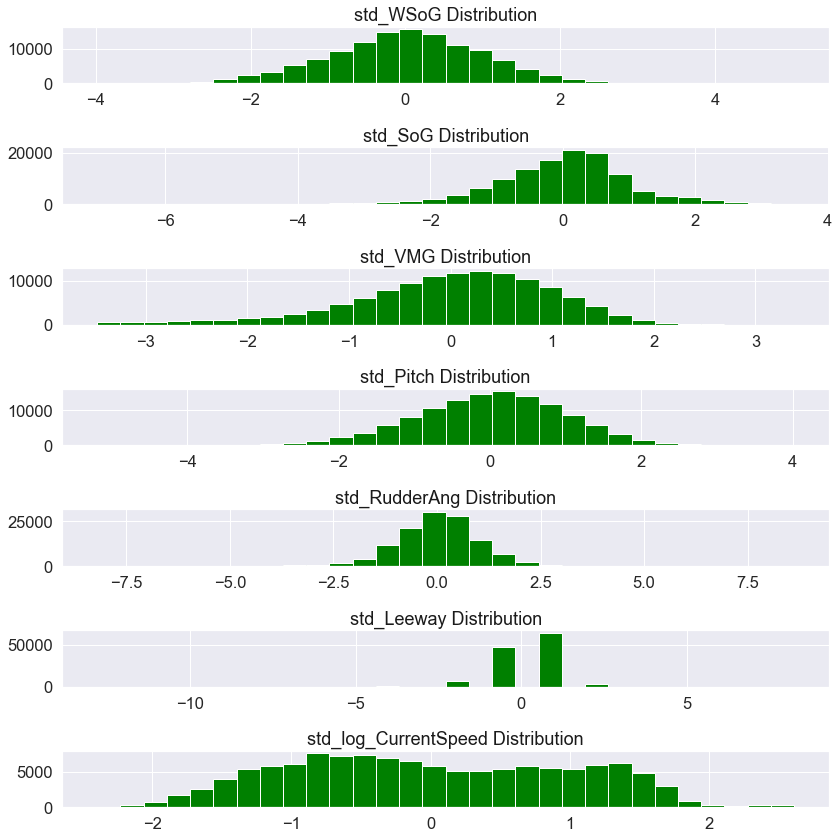

In [8]:
# Check distributions pre log_transform
# plot_histograms(df, pre_log_variables, 5, 1, 20)

# Check distributions of standarized variables
plot_histograms(df, std_vars, 7, 1, 30)

In [9]:
def plot_histograms(data,features,rows,cols, bins = 20):
    fig=plt.figure(figsize=(16,16))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        data[feature].hist(bins=bins,ax=ax,facecolor='green')
        ax.set_title(feature+" Distribution",color='k')

    fig.tight_layout()  
    plt.show()
    return

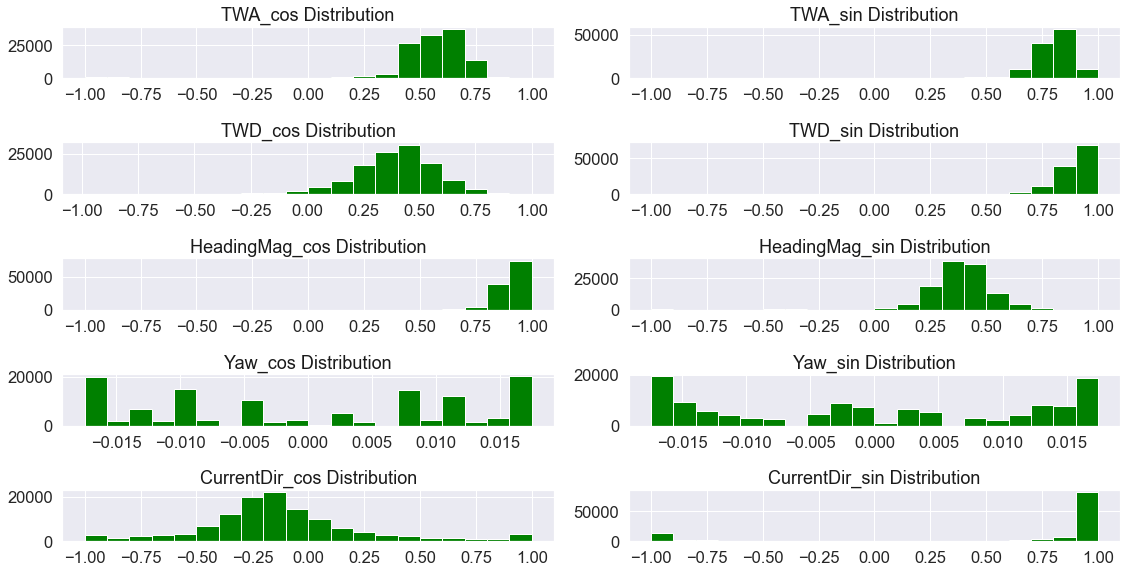

In [10]:
# Visualize Angle Features
plot_histograms(df, angle_vars, 10,2,20)

In [11]:
# Check scaled features summary statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Tacking,122240.0,9.459260e-02,0.292653,0.000000,0.000000,0.000000e+00,0.000000,1.000000
TWD_cos,122240.0,3.878906e-01,0.193813,-0.987688,0.275637,4.067366e-01,0.515038,0.999848
TWD_sin,122240.0,8.960114e-01,0.095611,-1.000000,0.857167,9.135455e-01,0.956305,1.000000
CurrentDir_cos,122240.0,-1.194960e-01,0.371637,-1.000000,-0.309017,-1.564345e-01,0.017452,1.000000
CurrentDir_sin,122240.0,5.970366e-01,0.700828,-1.000000,0.731354,9.612617e-01,0.990268,1.000000
HeadingMag_cos,122240.0,8.917419e-01,0.163792,-0.999848,0.874620,9.205049e-01,0.951057,1.000000
HeadingMag_sin,122240.0,3.720145e-01,0.198933,-1.000000,0.309017,3.907311e-01,0.469472,1.000000
Yaw_cos,122240.0,7.599248e-05,0.012333,-0.017453,-0.009430,-7.671689e-05,0.011408,0.017453
Yaw_sin,122240.0,-8.383810e-05,0.012349,-0.017453,-0.013208,-5.261182e-07,0.013209,0.017453
TWA_cos,122240.0,5.350954e-01,0.245418,-0.999848,0.484810,5.735764e-01,0.656059,1.000000


In [12]:
# Obtain Features and Labels for our models
X_train_copy = df.drop(df.columns[0], axis = 1)
y_train_copy = df['Tacking']

# Check dimension of training-validation data
print(X_train_copy.shape)
print(y_train_copy.shape)

(122240, 17)
(122240,)


### Preprocessing Holdout (unseen) set

In [13]:
# Read unseen data
df_unseen = pd.read_csv('./data/unseen_data.csv',header = 0)
df_unseen['DateTime'] = pd.to_datetime(df_unseen['DateTime'])
df_unseen.set_index('DateTime',inplace=True)
print(df_unseen.info())
df_unseen.reset_index(inplace=True)

# Drop those columns from the dataset
# df_unseen = df_unseen.drop(to_drop, axis=1)

# Print remaning columns
print(df_unseen.columns)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48799 entries, 2019-04-15 18:00:00 to 2019-04-16 07:33:19
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CurrentSpeed  48799 non-null  float64
 1   CurrentDir    48799 non-null  float64
 2   TWS           48799 non-null  float64
 3   TWA           48799 non-null  float64
 4   AWS           48799 non-null  float64
 5   AWA           48799 non-null  float64
 6   Roll          48799 non-null  float64
 7   Pitch         48799 non-null  float64
 8   HeadingMag    48799 non-null  float64
 9   HoG           48799 non-null  float64
 10  HeadingTrue   48799 non-null  float64
 11  AirTemp       48799 non-null  float64
 12  Longitude     48799 non-null  float64
 13  Latitude      48799 non-null  float64
 14  SoG           48799 non-null  float64
 15  SoS           48799 non-null  float64
 16  AvgSoS        48799 non-null  float64
 17  VMG           48799 non-null  floa

In [14]:
###############################
# Transforming positive angles
def positive_angle_transforms(df, columns): 
    """
    Function to express angle features in terms of cosine and sine
    This should capture the fact that 360 degrees in close to 0 degrees 
    """
    for col in columns:
        
        if col == 'Yaw':
            df[col+'_cos'] = np.cos(df[col] + 360) * np.pi / 180
            df[col+'_sin'] = np.sin(df[col] + 360) * np.pi / 180
        else:
            df[col+'_cos'] = np.cos(df[col] * np.pi / 180)
            df[col+'_sin'] = np.sin(df[col] * np.pi / 180)
        
    return df

positive_angle_cols = ['TWD', 'CurrentDir', 'HoG', 'HeadingTrue' ,'HeadingMag', 'Yaw']
df_unseen = positive_angle_transforms(df_unseen, positive_angle_cols)

###############################
# Transforming negative angles
def negative_angle_transforms(df, columns):
    for col in columns:
        
        df[col+'_cos'] = np.cos((df[col] + 360) * np.pi / 180)
        df[col+'_sin'] = np.sin((df[col] + 360) * np.pi / 180)
    
    return df

negative_angle_cols = ['TWA', 'AWA']
df_unseen = negative_angle_transforms(df_unseen, negative_angle_cols)

###############################
# Log PowerTransformer

# Log variables
pre_log_vars = ['CurrentSpeed', 'VoltageDrawn']
log_vars = ['log_CurrentSpeed', 'log_VoltageDrawn']

# ONLY Trasform log columns
df_unseen[log_vars] = log_transformer.transform(df_unseen[pre_log_vars])

###############################
# PowerTransformer (Box-Cox)

# BoxCox variables
pre_bc_vars = ['TWS', 'AWS']
bc_vars = ['bc_TWS', 'bc_AWS']

# Fit-Trasform BoxCox columns
df_unseen[bc_vars] = bc_transformer.transform(df_unseen[pre_bc_vars])


################################################################################################
# Create range of categories for SoS. Its distribution is not so "well behaved". 
# If I want to include it in my analysis. I would use One Hot Encoder on this categorical variable
label_ranges = [0, 2, 4, 6, 8, np.inf]
label_names = [0, 1, 2, 3, 4]

# Create wait_type column
df_unseen['AvgSoS_cat'] = pd.cut(df_unseen['AvgSoS'], bins = label_ranges, 
                                labels = label_names)

df_unseen['AvgSoS_cat'] = df_unseen['AvgSoS_cat'].astype('int') 

###############################
# Standard Scaler

# Variables to scale
pre_std_vars = ['Pitch','Roll','RudderAng', 'Leeway', 'WSoG', 'SoG', 'SoS', 'VMG', 'AirTemp',
                'log_CurrentSpeed', 'log_VoltageDrawn',
                'bc_TWS', 'bc_AWS']

# Fit-Transform columns
std_df_unseen = pd.DataFrame(std_scaler.transform(df_unseen[pre_std_vars]))
std_df_unseen.columns = ['std_' + col for col in pre_std_vars]

#####################################################################
# Concatenate Raw Variables + Angle Variables + Standarized Variables
df_unseen = pd.concat([df_unseen, std_df_unseen], axis=1)

# Drop all unwanted variables
df_unseen = df_unseen.drop(to_drop, axis=1)

In [15]:
# Create a data with all columns except target
X_unseen = df_unseen.drop("Tacking", axis=1)

# Create a labels column
y_unseen = df_unseen[["Tacking"]]

In [16]:
def plot_histograms(data,features,rows,cols, bins = 20):
    fig=plt.figure(figsize=(12,12))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        data[feature].hist(bins=bins,ax=ax,facecolor='green')
        ax.set_title(feature+" Distribution",color='k')

    fig.tight_layout()  
    plt.show()
    return

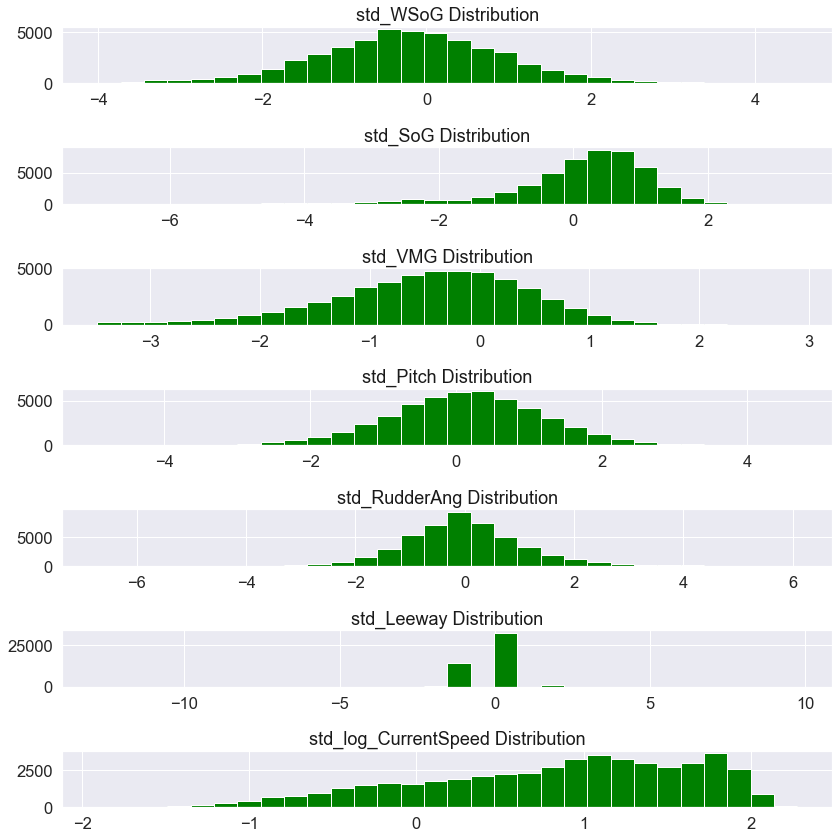

In [17]:
# Check distributions pre log_transform
# plot_histograms(df, pre_log_variables, 5, 1, 20)

# Check distributions of standarized variables
plot_histograms(df_unseen, std_vars, 7, 1, 30)


In [18]:
def plot_histograms(data,features,rows,cols, bins = 20):
    fig=plt.figure(figsize=(16,16))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        data[feature].hist(bins=bins,ax=ax,facecolor='green')
        ax.set_title(feature+" Distribution",color='k')

    fig.tight_layout()  
    plt.show()
    return

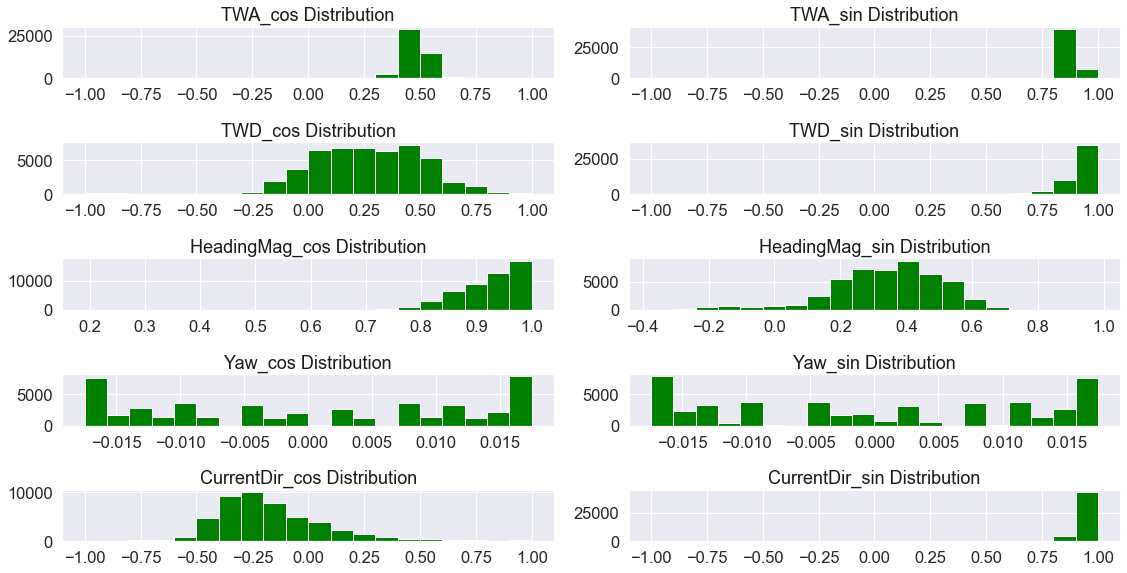

In [19]:
# Visualize Angle Features
plot_histograms(df_unseen, angle_vars, 10,2,20)

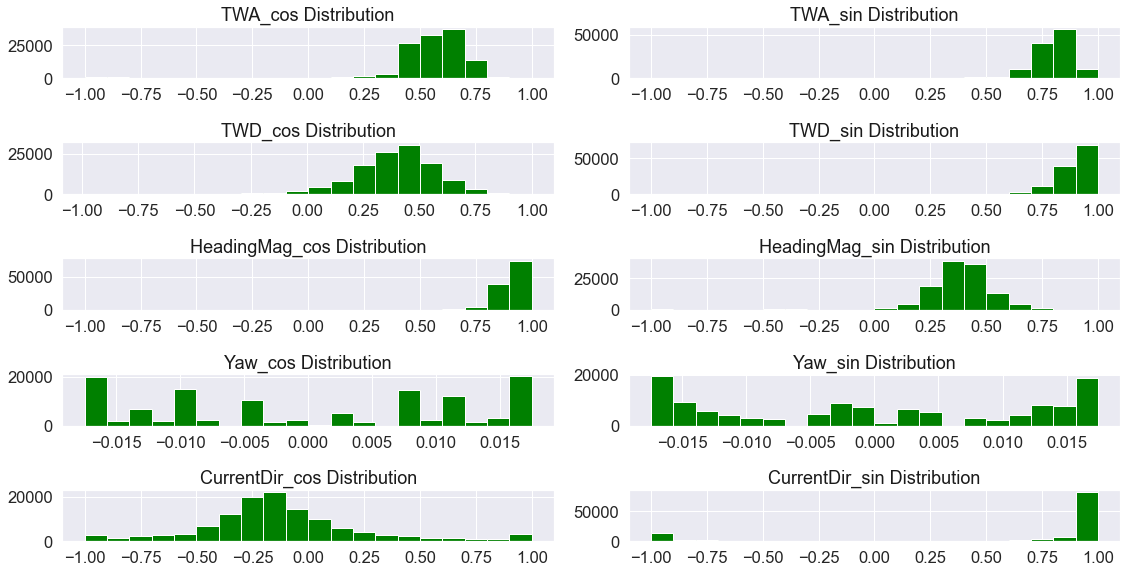

In [20]:
plot_histograms(df, angle_vars, 10,2,20)

In [21]:
# Check scaled features summary statistics
df_unseen.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Tacking,48799.0,0.113117,0.316739,0.000000,0.000000,0.000000e+00,0.000000,1.000000
TWD_cos,48799.0,0.258684,0.256447,-1.000000,0.087156,2.588190e-01,0.453990,1.000000
TWD_sin,48799.0,0.916607,0.164775,-1.000000,0.891007,9.612617e-01,0.992546,1.000000
CurrentDir_cos,48799.0,-0.165354,0.256163,-1.000000,-0.325568,-2.079117e-01,-0.052336,1.000000
CurrentDir_sin,48799.0,0.943239,0.131684,-0.999391,0.933580,9.702957e-01,0.992546,1.000000
HeadingMag_cos,48799.0,0.922438,0.060528,0.190809,0.882948,9.335804e-01,0.970296,1.000000
HeadingMag_sin,48799.0,0.340896,0.170983,-0.374607,0.241922,3.583679e-01,0.469472,0.981627
Yaw_cos,48799.0,0.000056,0.012334,-0.017453,-0.013158,-7.671689e-05,0.011409,0.017453
Yaw_sin,48799.0,-0.000155,0.012347,-0.017453,-0.013208,-5.261182e-07,0.011466,0.017453
TWA_cos,48799.0,0.472259,0.131524,-0.999848,0.453990,4.848096e-01,0.515038,1.000000


In [22]:
# Obtain Features and Labels for our models
X_test_copy = df_unseen.drop(df_unseen.columns[0], axis = 1)
y_test_copy = df_unseen['Tacking']

# Check dimension of training-validation data
print(X_test_copy.shape)
print(y_test_copy.shape)

(48799, 17)
(48799,)


In [23]:
# Padding Training and Testing for reshaping into 3D
X_train_df = X_train_copy.copy()
X_test_df = X_test_copy.copy().append( X_test_copy.iloc[[-1]*1] )
y_train_df = y_train_copy.copy()
y_test_df = y_test_copy.copy().append( y_test_copy.iloc[[-1]*1] )
print("X_train shape:",X_train_df.shape)
print("y_train shape:",y_train_df.shape)
print("X_test shape:",X_test_df.shape)
print("y_test shape:",y_test_df.shape)

X_train shape: (122240, 17)
y_train shape: (122240,)
X_test shape: (48800, 17)
y_test shape: (48800,)


## Tree Method with Feature Engineering

In [24]:
def build_kf_dt_gsCV_model(X , y):

    # Decision Tree Classifier with Stratified K Fold
    sKF = StratifiedKFold(n_splits=5)

    index_iterator = sKF.split(X, np.ravel(y))

    params_dt = {
                 'max_depth': [3,5,7,9],
                 'min_samples_leaf': [2, 10, 100],
                 'min_samples_split': [2, 500, 1000],
                 # 'max_features' : [None,'log2','sqrt'],
                   # 'class_weight': ['balanced'],
                    'criterion': ['entropy','gini']}

    # Instantiate GridSearchCV with index_iterator
    skf_grid_dt = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=params_dt, scoring='roc_auc', cv = index_iterator,
                                    verbose=1, n_jobs = -1)

    # Fit DT to the training-validation set
    skf_grid_dt.fit(X,np.ravel(y))

    # Extract the best estimator
    dt_kf_best_model = skf_grid_dt.best_estimator_

    # Print models best params
    print(dt_kf_best_model.get_params())
    
    return dt_kf_best_model, skf_grid_dt

# Run sKF for Decision Trees
dt_kf_best_model = build_kf_dt_gsCV_model(X_train_df , y_train_df)[0]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   22.9s finished


{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 100, 'min_samples_split': 500, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


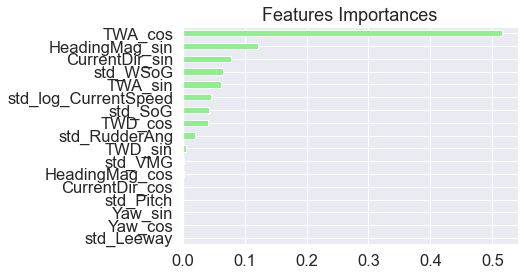

In [25]:
# Create a Series to visualize features importances
importances = pd.Series(data=dt_kf_best_model.feature_importances_,
                        index= X_train_df.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [26]:
# Evaluating Stratified K Folds Metrics
try:
    # Check current SKFolds dt model
    print(dt_kf_best_model.get_params())

    # Predict on unseen dataset
    y_pred_dt = dt_kf_best_model.predict(X_test_df)

    # Compute confusion matrix
    conf_mat = confusion_matrix(y_test_df, y_pred_dt)
    print("Confusion Matrix: \n",conf_mat)

    # Compute classification report
    report = classification_report(y_test_df, y_pred_dt)
    print("Report: \n",report)

except:
    pass

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 100, 'min_samples_split': 500, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}
Confusion Matrix: 
 [[40435  2845]
 [ 5406   114]]
Report: 
               precision    recall  f1-score   support

         0.0       0.88      0.93      0.91     43280
         1.0       0.04      0.02      0.03      5520

    accuracy                           0.83     48800
   macro avg       0.46      0.48      0.47     48800
weighted avg       0.79      0.83      0.81     48800



### Logistic Regression

In [27]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_df, y_train_df, test_size = 0.2, stratify = y_train_df)

In [28]:
# Instantiate LogisticRegression classifier
lr = LogisticRegression(max_iter = 1000)

# Fit the LR classifier
lr.fit(X_tr, y_tr)

# Predict on unseen dataset
y_pred_lr = lr.predict(X_val)

# Compute confusion matrix
conf_mat = confusion_matrix(y_val, y_pred_lr)
print("Confusion Matrix: \n",conf_mat)

# Compute classification report
report = classification_report(y_val, y_pred_lr)
print("Report: \n",report)

# Predict on unseen dataset
y_pred_lr = lr.predict(X_test_df)

# Compute confusion matrix
conf_mat = confusion_matrix(y_test_df, y_pred_lr)
print("Confusion Matrix: \n",conf_mat)

# Compute classification report
report = classification_report(y_test_df, y_pred_lr)
print("Report: \n",report)

Confusion Matrix: 
 [[22061    74]
 [  755  1558]]
Report: 
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     22135
         1.0       0.95      0.67      0.79      2313

    accuracy                           0.97     24448
   macro avg       0.96      0.84      0.89     24448
weighted avg       0.97      0.97      0.96     24448

Confusion Matrix: 
 [[41517  1763]
 [ 5520     0]]
Report: 
               precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     43280
         1.0       0.00      0.00      0.00      5520

    accuracy                           0.85     48800
   macro avg       0.44      0.48      0.46     48800
weighted avg       0.78      0.85      0.82     48800



### Linear SVM

In [43]:
# Instantiate linear SVM classifier
lsvm = LinearSVC(max_iter = 10000)

# Fit the SVM classifier
lsvm.fit(X_tr, y_tr)

# Predict on unseen dataset
y_pred_lsvm = lsvm.predict(X_val)

# Compute confusion matrix
conf_mat = confusion_matrix(y_val, y_pred_lsvm)
print("Confusion Matrix: \n",conf_mat)

# Compute classification report
report = classification_report(y_val, y_pred_lsvm)
print("Report: \n",report)

# Predict on unseen dataset
y_pred_lsvm = lsvm.predict(X_test_df)

# Compute confusion matrix
conf_mat = confusion_matrix(y_test_df, y_pred_lsvm)
print("Confusion Matrix: \n",conf_mat)

# Compute classification report
report = classification_report(y_test_df, y_pred_lsvm)
print("Report: \n",report)

Confusion Matrix: 
 [[22083    52]
 [  791  1522]]
Report: 
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     22135
         1.0       0.97      0.66      0.78      2313

    accuracy                           0.97     24448
   macro avg       0.97      0.83      0.88     24448
weighted avg       0.97      0.97      0.96     24448

Confusion Matrix: 
 [[42342   938]
 [ 5520     0]]
Report: 
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     43280
         1.0       0.00      0.00      0.00      5520

    accuracy                           0.87     48800
   macro avg       0.44      0.49      0.46     48800
weighted avg       0.78      0.87      0.82     48800



### SVM

In [44]:
# Instantiate linear SVM classifier
svm = LinearSVC(max_iter = 10000)

# Fit the SVM classifier
svm.fit(X_tr, y_tr)

# Predict on unseen dataset
y_pred_svm = svm.predict(X_val)

# Compute confusion matrix
conf_mat = confusion_matrix(y_val, y_pred_svm)
print("Confusion Matrix: \n",conf_mat)

# Compute classification report
report = classification_report(y_val, y_pred_svm)
print("Report: \n",report)

# Predict on unseen dataset
y_pred_svm = svm.predict(X_test_df)

# Compute confusion matrix
conf_mat = confusion_matrix(y_test_df, y_pred_svm)
print("Confusion Matrix: \n",conf_mat)

# Compute classification report
report = classification_report(y_test_df, y_pred_svm)
print("Report: \n",report)

Confusion Matrix: 
 [[22083    52]
 [  791  1522]]
Report: 
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     22135
         1.0       0.97      0.66      0.78      2313

    accuracy                           0.97     24448
   macro avg       0.97      0.83      0.88     24448
weighted avg       0.97      0.97      0.96     24448

Confusion Matrix: 
 [[42342   938]
 [ 5520     0]]
Report: 
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     43280
         1.0       0.00      0.00      0.00      5520

    accuracy                           0.87     48800
   macro avg       0.44      0.49      0.46     48800
weighted avg       0.78      0.87      0.82     48800



## Predicting `Tacking` with LSTM Architecture

In [30]:
%%capture
!pip install tensorflow
!pip install keras

In [31]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [32]:
# Reshaping Training and Test as input for LSTM 
time_steps = 10*2*2*2*2 # Intervals of 160 s = 2.67 min
X_train= X_train_df.values.reshape((X_train_df.shape[0], 1, X_train_df.shape[1]))
y_train = y_train_df.values
X_test= X_test_df.values.reshape(X_test_df.shape[0], 1, X_train_df.shape[1])
y_test = y_test_df.values
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (122240, 1, 17)
y_train shape: (122240,)
X_test shape: (48800, 1, 17)
y_test shape: (48800,)


In [33]:
# Build Neural Net Arquitecture
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1 , activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                13600     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 13,651
Trainable params: 13,651
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Fit Network
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split = 0.2, verbose=2, shuffle=False)


Epoch 1/10
3056/3056 - 3s - loss: 0.1910 - accuracy: 0.9370 - val_loss: 0.0696 - val_accuracy: 1.0000
Epoch 2/10
3056/3056 - 3s - loss: 0.1758 - accuracy: 0.9465 - val_loss: 0.0716 - val_accuracy: 1.0000
Epoch 3/10
3056/3056 - 3s - loss: 0.1634 - accuracy: 0.9516 - val_loss: 0.0750 - val_accuracy: 1.0000
Epoch 4/10
3056/3056 - 3s - loss: 0.1574 - accuracy: 0.9557 - val_loss: 0.0791 - val_accuracy: 1.0000
Epoch 5/10
3056/3056 - 3s - loss: 0.1554 - accuracy: 0.9565 - val_loss: 0.0787 - val_accuracy: 1.0000
Epoch 6/10
3056/3056 - 3s - loss: 0.1541 - accuracy: 0.9566 - val_loss: 0.0780 - val_accuracy: 1.0000
Epoch 7/10
3056/3056 - 3s - loss: 0.1533 - accuracy: 0.9566 - val_loss: 0.0766 - val_accuracy: 1.0000
Epoch 8/10
3056/3056 - 3s - loss: 0.1525 - accuracy: 0.9567 - val_loss: 0.0773 - val_accuracy: 1.0000
Epoch 9/10
3056/3056 - 3s - loss: 0.1515 - accuracy: 0.9570 - val_loss: 0.0771 - val_accuracy: 1.0000
Epoch 10/10
3056/3056 - 3s - loss: 0.1504 - accuracy: 0.9572 - val_loss: 0.0757 - 

In [35]:
# Evaluate your model accuracy on the test set
accuracy = model.evaluate(X_test, y_test)[1]

# Print accuracy
print('Accuracy:', accuracy)

1525/1525 [==============================] - 1s 565us/step - loss: 0.5062 - accuracy: 0.8825
Accuracy: 0.8824590444564819


In [36]:
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()
    
def plot_accuracy(acc,val_acc):
  plt.figure()
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

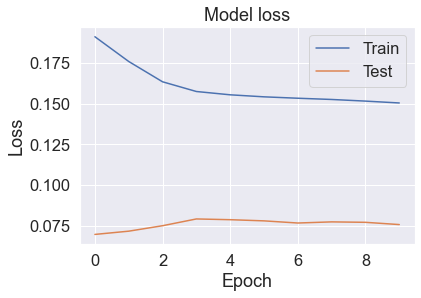

In [37]:
# Plot Train-Validation Loss through epochs
plot_loss(history.history['loss'], history.history['val_loss'])

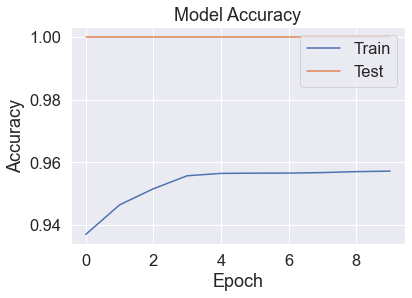

In [38]:
# Plot Train-Validation Accuracy through epochs
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

In [39]:
# Predict on X_test and round up the predictions
preds = model.predict(X_test)

# Print rounded preds
print('Predictions: \n', preds)

preds.shape

Predictions: 
 [[0.05049431]
 [0.04811186]
 [0.04198721]
 ...
 [0.08247966]
 [0.10617593]
 [0.10617593]]


(48800, 1)

In [40]:
# Tuning Decision Threshold for X_test
preds_df = pd.DataFrame()

preds_df['probas'] = model.predict(X_train)[:,0]

# Get Predictions
threshold = 0.15

preds_df.loc[preds_df['probas'] < threshold , 'predict'] = 0 
preds_df.loc[preds_df['probas'] >= threshold , 'predict'] = 1 

# Compute confusion matrix
conf_mat = confusion_matrix(y_train, preds_df['predict'])
print("Confusion Matrix: \n",conf_mat)

# Compute classification report
report = classification_report(y_train, preds_df['predict'])
print("Report: \n",report)

Confusion Matrix: 
 [[109324   1353]
 [  4627   6936]]
Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97    110677
         1.0       0.84      0.60      0.70     11563

    accuracy                           0.95    122240
   macro avg       0.90      0.79      0.84    122240
weighted avg       0.95      0.95      0.95    122240



In [41]:
# Tuning Decision Threshold for X_test
preds_df = pd.DataFrame()

preds_df['probas'] = model.predict(X_test)[:,0]

# Get Predictions
threshold = 0.5

preds_df.loc[preds_df['probas'] < threshold , 'predict'] = 0 
preds_df.loc[preds_df['probas'] >= threshold , 'predict'] = 1 

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, preds_df['predict'])
print("Confusion Matrix: \n",conf_mat)

# Compute classification report
report = classification_report(y_test, preds_df['predict'])
print("Report: \n",report)

Confusion Matrix: 
 [[43064   216]
 [ 5520     0]]
Report: 
               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     43280
         1.0       0.00      0.00      0.00      5520

    accuracy                           0.88     48800
   macro avg       0.44      0.50      0.47     48800
weighted avg       0.79      0.88      0.83     48800



## LSTM Architecture with Time Window